# Data Exploration

For our dataset, we chose the UrbanSound8K dataset (J. Salamon, C. Jacoby and J. P. Bello, "A Dataset and Taxonomy for Urban Sound Research", 22nd ACM International Conference on Multimedia, Orlando USA, Nov. 2014.)

The data is available through this link: https://zenodo.org/record/1203745

The data consists of single-audio-channel WAV files of varying lengths and quality, each classified into one of 10 classes. No extracted features are provided as part of this data set; we will extract some in another notebook. The data are already separated into 10 training folds, and the providers of the dataset recommend using the folds as provided to avoid data leakage, as some of the audio files are fragments of larger files.

##### Running this notebook

As the dataset is too large to feasibly upload to Github, it needs to be downloaded separately from the aforementioned link and extracted into a directory named 'large_data', should the reader wish to run this notebook. We only include the metadata CSV found in the dataset, as it is small enough to be stored on Github.

## Preparations

We load in required packages, as well as the metadata file provided along with the dataset.

In [2]:
# Standard data handling and plotting packages
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

# Librosa is a widely use audio analysis package
# NOTE: librosa dependencies apparently require specific versions of numpy, try numpy==1.21.4 if encountering issues
import librosa
import librosa.display

# We can listen to the audio files by importing this package
import IPython.display

In [19]:
# Data should be placed in the "large_data/" directory, which is not staged in the git repo

# The dataset includes a metadata CSV that lists the audio file names, pre-chosen fold, class label, etc.
metadata = pd.read_csv('large_data/UrbanSound8K/metadata/UrbanSound8K.csv')
metadata.info()
metadata.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8732 entries, 0 to 8731
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   slice_file_name  8732 non-null   object 
 1   fsID             8732 non-null   int64  
 2   start            8732 non-null   float64
 3   end              8732 non-null   float64
 4   salience         8732 non-null   int64  
 5   fold             8732 non-null   int64  
 6   classID          8732 non-null   int64  
 7   class            8732 non-null   object 
dtypes: float64(2), int64(4), object(2)
memory usage: 545.9+ KB


,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


## Dataset balance

Before attempting to build a classifier, we have to check how balanced the dataset is. We list the unique classes and check their distribution, as well as the distribution of audio file lengths. We pay special attention to data of the "gun_shot" class, as our main goal in this project is the detection of such audio signals.

In [17]:
# Simple way to have a dict relating classID to class
class_dict = {}
for index, row in metadata.iterrows():
    class_dict[row['classID']]=row['class']

# We can check how many class labels there are, and what they are
print(f'\nNumber of unique classes: {len(class_dict)}\n')
for i in range(len(class_dict)):
    print(f'{i} {class_dict[i]}')


Number of unique classes: 10

0 air_conditioner
1 car_horn
2 children_playing
3 dog_bark
4 drilling
5 engine_idling
6 gun_shot
7 jackhammer
8 siren
9 street_music


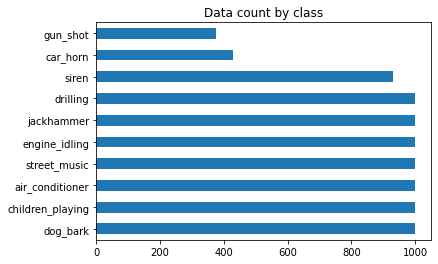

There are 374 gun_shot sounds, 4% of total sounds.


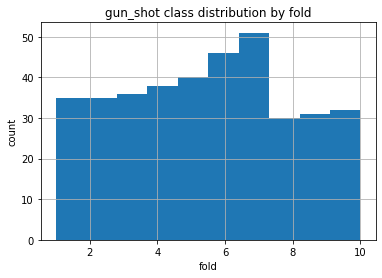

In [27]:
# Plot the number of data files from each class
counts = metadata['class'].value_counts()
counts.plot(kind='barh')
plt.title('Data count by class')
plt.show()

# We pay special attention to the "gun_shot" class
print(f'There are {counts["gun_shot"]} gun_shot sounds, {round(100*(counts["gun_shot"]/sum(counts)))}% of total sounds.')
metadata_gun_shot = metadata[metadata['class']=='gun_shot']

# Checking that "gun_shot" class is well distributed among provided folds
metadata_gun_shot.hist(column='fold')
plt.title('gun_shot class distribution by fold')
plt.xlabel('fold')
plt.ylabel('count')
plt.show()

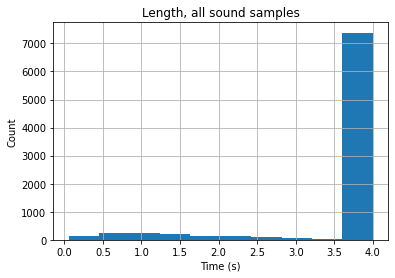

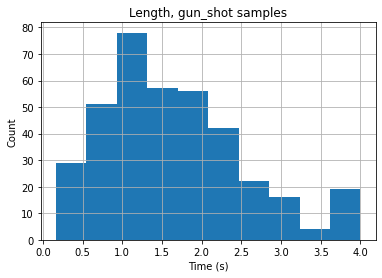

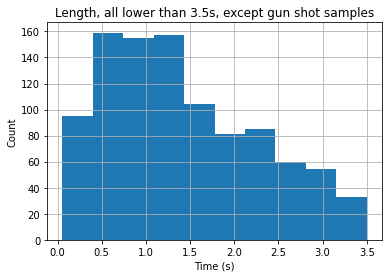

Total counts: (All)=8732, (Gun)=374, (Non-Gun sub 3.5s)=983


In [30]:
# Check the distribution of sound lengths
audio_length = metadata['end'] - metadata['start']
audio_length.hist()
plt.xlabel('Time (s)')
plt.ylabel('Count')
plt.title('Length, all sound samples')
plt.show()

audio_length_gun_shot = metadata_gun_shot['end'] - metadata_gun_shot['start']
audio_length_gun_shot.hist()
plt.xlabel('Time (s)')
plt.ylabel('Count')
plt.title('Length, gun_shot samples')
plt.show()

metadata_non_shot = metadata[(metadata['class']!='gun_shot') & (audio_length<3.5)]
audio_length_non_shot = metadata_non_shot['end'] - metadata_non_shot['start']
audio_length_non_shot.hist()
plt.xlabel('Time (s)')
plt.ylabel('Count')
plt.title('Length, all lower than 3.5s, except gun shot samples')
plt.show()

print(f'Total counts: (All)={len(audio_length)}, (Gun)={len(audio_length_gun_shot)}, (Non-Gun sub 3.5s)={len(audio_length_non_shot)}')

We see that, though the gun_shot class is well distributed among folds, its total number of data is a factor of 2-3 less than most other classes.

We also see that most audio files are 4.0s in length, but gunshots tend to be shorter. We will have to account for the variety of audio file lengths when picking audio features, to avoid having the ML model learning about the length rather than the content of the file.

## Examining individual audio files

To get a better idea of what we are dealing with, we also check the properties of a few individual files using common audio analysis and visualization methods.

In [8]:
# Function to load wav file with librosa, given a row from metadata table
def load_data(meta_row):
    filename = meta_row['slice_file_name']
    filepath = f'large_data/UrbanSound8K/audio/fold{meta_row["fold"]}/'
    return librosa.load(filepath+filename)

In [31]:
# Function to get various visualizations for a data row
def visualize_data(row):
    
    print(f'Class: {row["class"]}')
    print(f'Duration: {round(row["end"]-row["start"],3)}s')
    print(f'Salience: {"foreground" if row["salience"]==1 else "background"}')
    y,sr = load_data(row)

    # Allow audio playback, but rescale amplitude to cap volume (some of these are loud!)
    max_amp = max(abs(y))
    y_norm = np.copy(y)/(max_amp*10)
    display(IPython.display.Audio(data=y_norm, rate=sr, normalize=False))
    
    # Plot the waveform. Mostly equivalent to plt.plot(y)
    librosa.display.waveshow(y,sr=sr)
    plt.title('Waveform')
    plt.show()
    
    # Fourier transform
    yF = np.abs(np.fft.fft(y))
    plt.plot(yF[:len(yF)//2])
    plt.title('Fourier Transform')
    plt.show()
    
    # Short-Time Fourier transform, basically calculate the fourier transform of consecutive small time windows, giving a 2D function as output
    ySF = np.abs(librosa.stft(y, n_fft=512))
    librosa.display.specshow(ySF, x_axis='time', y_axis='linear')
    plt.colorbar()
    plt.title('Short-Time Fourier Transform')
    plt.show()
    S_db = librosa.amplitude_to_db(ySF, ref=np.max) # Converting to decibell is effectively just a logarithmic transform 
    librosa.display.specshow(S_db, x_axis='time', y_axis='linear')
    plt.colorbar()
    plt.title('Logarithmic Short-Time Fourier Transform')
    plt.show()
    

Our visualizations reveal that some of the data files are quite noisy: dog barks drowned out by cheering crowds, street music barely audible behind urban noise, mislabeled air conditioners... Here are some examples.

Class: dog_bark
Duration: 3.1s
Salience: background


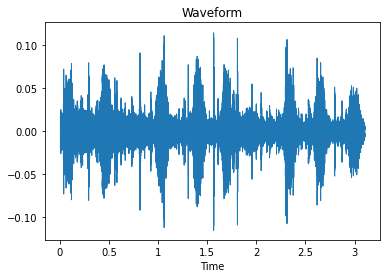

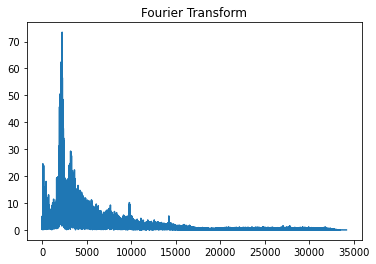

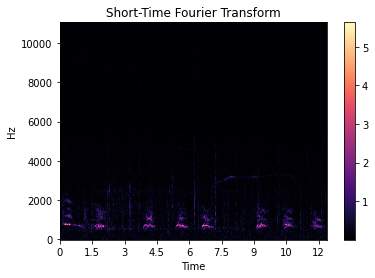

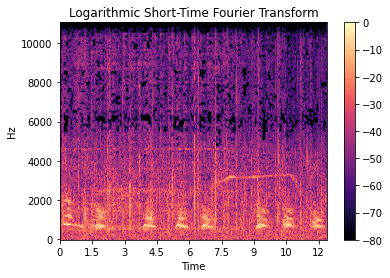

In [35]:
# Datum labeled as dog bark, but clapping and cheering crowd can be clearly heard.
row_ind = 100
visualize_data(metadata.iloc[row_ind])

Class: street_music
Duration: 4.0s
Salience: background


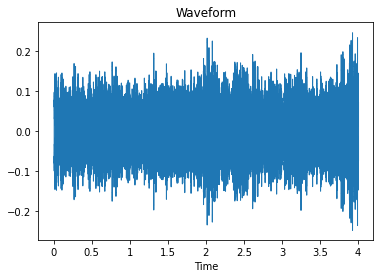

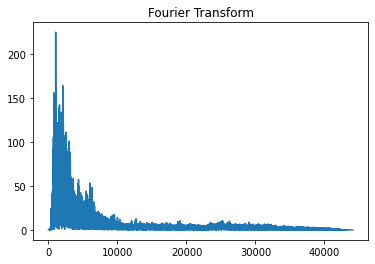

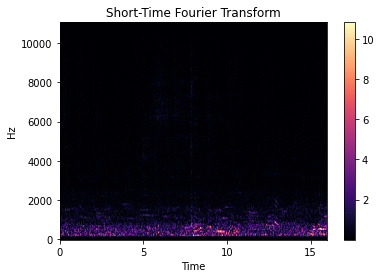

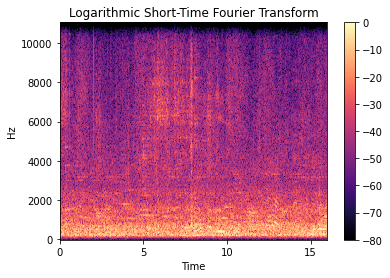

In [43]:
# Barely audible guitar (?), drowned out by crowd noise.
row_ind = 90
visualize_data(metadata[metadata['class']=='street_music'].iloc[row_ind])

Class: air_conditioner
Duration: 4.0s
Salience: background


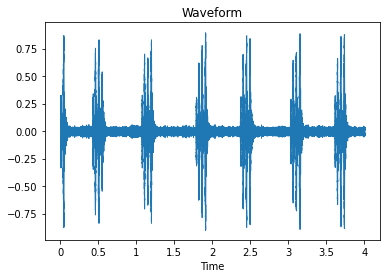

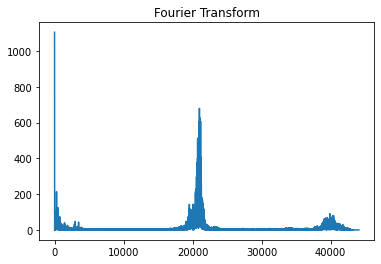

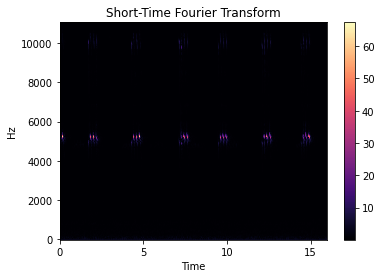

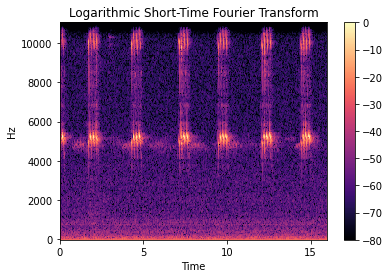

In [54]:
# A datum labeled 'air_conditioner', but the only audible sound is a very loud cricket!
row_ind = 40
visualize_data(metadata[metadata['class']=='air_conditioner'].iloc[row_ind])

Given the noisiness/incorrectness of some labels, we can expect to have difficulty classifying some of the data.

We also check specifically gunshots. We notice they have much 'sharper' peaks in their waveforms, a feature that will likely be useful in their classification.

Class: gun_shot
Duration: 2.612s
Salience: foreground


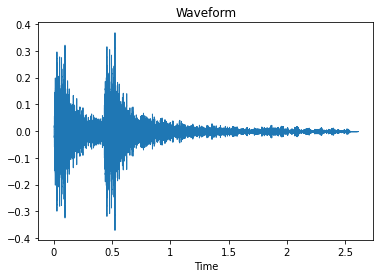

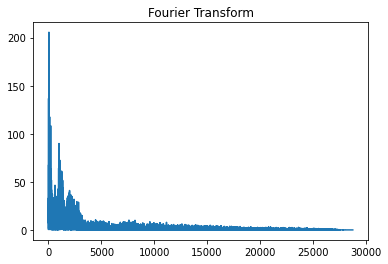

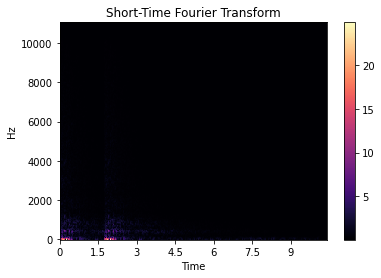

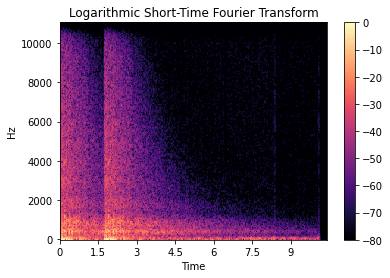

In [55]:
# Visualize specifically a gun_shot datum
row_ind = 0
visualize_data(metadata[metadata['class']=='gun_shot'].iloc[row_ind])